#Milestone Project: SKIMLIT

The purpose of the project is to build a Natural Processing Language(NLP) model to make reading medical abstraction easier

The paper used is: https://arxiv.org/abs/1710.06071v1

And reading through the paper above, we can see that the model architecture that they use to acheive their best results

##Confirm access to GPU

In [1]:
!nvidia-smi

Tue Dec 10 08:57:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##Get data
We will be working on PubMed 200k RCT

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 30.74 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

##Preprocess data
Got a data, it's time to become one with it and visualize it

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

###Representing data in the best way

[{'line_number':0,

   'target':'Background',

   'text':"Adrenergic activation is thought to be an important determinant of outcome in subjects with chronic heart failure ( CHF ) , but baseline or serial changes in adrenergic activity have not been previously investigated in a large patient sample treated with a powerful antiadrenergic agent .\n'",
   
   'total_lines':11}]


In [8]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line # add line to abstract
  return abstract_samples

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 731 ms, sys: 111 ms, total: 842 ms
Wall time: 1.04 s


(180040, 30212, 30135)

In [10]:
#Check first abstract of our training samples
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Data is in the format of a list of dictionary, now turning it into DataFrame to visualize it

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
#Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


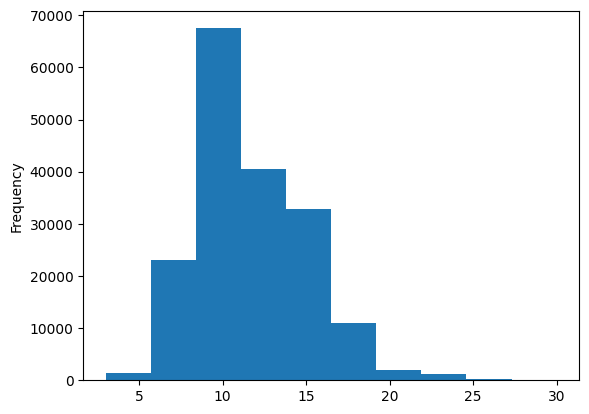

In [13]:
train_df.total_lines.plot.hist();

###Get lists of sentences
When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the tolist() method on our "text" columns

In [14]:
#Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

##Making numeric labels(ML models requires numeric labels)
To numerically encode labels we'll use Scikit-Learn's OneHotEncoder and LabelEncoder classes.

In [16]:
#one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
#train_labels.shape, val_labels.shape, test_labels.shape

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

###Label encoder labels

In [18]:
#Extract labels("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"])
val_labels_encoded = label_encoder.fit_transform(val_df["target"])
test_labels_encoded = label_encoder.fit_transform(test_df["target"])

#Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
#Get classes names and no.of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##Model 0:Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create pipeline
model_0 = Pipeline([
            ("tf_idf", TfidfVectorizer()),
            ("clf", MultinomialNB())
])
#Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
#Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
#Make predictions using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

###Download helper functions script
calculate_results() function calculates:

* Accuracy
* Precision
* Recall
* F1-score

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-12-10 08:58:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-12-10 08:58:07 (15.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##Preparing data(the text) for deep sequence models
Creating vectorization and embedding layers

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [26]:
#How long is each sentence average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

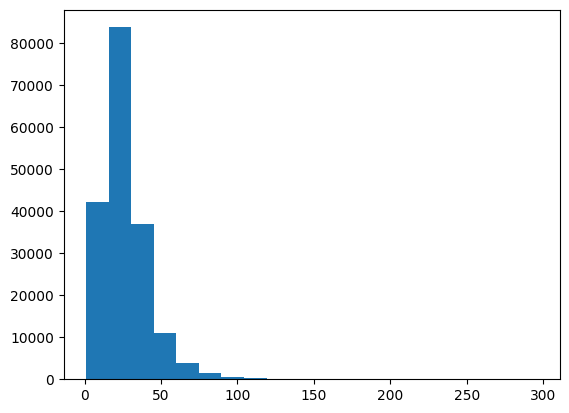

In [27]:
#What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20)

In [28]:
#How long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [29]:
#Max sequence length in the training set
max(sent_lens)

296

###Create text vectorizer layer
Layer which maps our text from words to numbers

In [30]:
#How many words in our vocab
max_tokens = 68000

sentence length of 55 covers 95% of the training sentences, we'll use that as our output_sequence_length parameter.

In [31]:
#Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, #no.of words in vocab
                                    output_sequence_length=output_seq_len #desired o/p length of vectorized sequences
                                    )

In [32]:
#Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
#Testout text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
( @ ) positive rate of blocking antibodies : the positive rate of blocking antibodies were @ % ( @/@ ) , @ % ( @/@ ) , @ % ( @/@ ) and @ % ( @/@ ) in the @ , @ , @ , and @ times of intradermal injection group , respectively ( p < @ ) .

Length of text: 62

Vectorized text:
[[ 280   78    4 5372 2190    2  280   78    4 5372 2190    9    3    5
     2    3  361    4 5833  390   13   83   14    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


Using the get_vocabulary() method of text_vectorizer we can find out a few different tidbits about our text.





In [34]:
#How many words in training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Top 5 words in vocab:{(rct_20k_text_vocab[:5])}")
print(f"Bottom 5 words in vocab:{(rct_20k_text_vocab[-5:])}")

Number of words in vocab: 64841
Top 5 words in vocab:['', '[UNK]', 'the', 'and', 'of']
Bottom 5 words in vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
#Get config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

###Creat custom text embedding

In [36]:
from tensorflow.keras import layers
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
( @ ) positive rate of blocking antibodies : the positive rate of blocking antibodies were @ % ( @/@ ) , @ % ( @/@ ) , @ % ( @/@ ) and @ % ( @/@ ) in the @ , @ , @ , and @ times of intradermal injection group , respectively ( p < @ ) .

Sentence after vectorization (before embedding):
[[ 280   78    4 5372 2190    2  280   78    4 5372 2190    9    3    5
     2    3  361    4 5833  390   13   83   14    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.02192403  0.02974656  0.03813826 ... -0.02018361  0.01440324
    0.00463105]
  [-0.00882082 -0.03970345 -0.03725073 ...  0.04484772  0.03694986
   -0.03159602]
  [ 0.04980997  0.03723988  0.00777913 ... -0.03900649 -0.0283208
   -0.0378769 ]
  ...
  [ 0.01645912 -0.02641052 -0.04146362 ... -0.04531104  0.02340445
   -0.01178634]
  [ 0.01645912 -0.02641052 -0.0414

##Creating datasets(making sure our data loads as much as possible)
Setting up our data to run as fast as possible with Tensorflow tf.data.API

In [37]:
#Turn our data into Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_encoded))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_encoded))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [38]:
#Take the TensorSlice Datasets and turn them into prefetched data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

##Model 1:Conv1D with token embedding
###Architecture
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)


In [39]:
from tensorflow.keras import layers
#Create 1D conv model to process sequence
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

#Compile the model
model_1.compile(loss="sparse_categorical_crossentropy", # labels are integer form (not one hot) use sparse_categorical crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset))) # only validate on 10% of batches


Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5287 - loss: 1.1659 - val_accuracy: 0.7397 - val_loss: 0.6975
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7448 - loss: 0.6847 - val_accuracy: 0.7776 - val_loss: 0.6225
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7722 - loss: 0.6229 - val_accuracy: 0.7896 - val_loss: 0.5892


In [40]:
#Model summary
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,022,993 (95.46 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,681,996 (63.64 MB)

In [41]:
#Evaluate on whole dataset
model_1.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7866 - loss: 0.5945


[0.5964870452880859, 0.786806583404541]

In [42]:
#Make predictions
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs.shape, model_1_pred_probs[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


((30212, 5),
 array([[4.30807412e-01, 1.13444924e-01, 7.78749064e-02, 3.51955742e-01,
         2.59170663e-02],
        [4.56687033e-01, 2.63576359e-01, 9.12405085e-03, 2.62610793e-01,
         8.00175592e-03],
        [1.69060379e-01, 6.48740120e-03, 1.86033663e-03, 8.22546184e-01,
         4.57638598e-05],
        [1.58460552e-05, 5.02695271e-04, 9.83186007e-01, 1.93363485e-05,
         1.62760951e-02],
        [9.83691076e-04, 4.77366000e-02, 2.72933245e-01, 9.96341463e-04,
         6.77350104e-01],
        [2.14979947e-02, 2.99720429e-02, 5.67945838e-01, 1.23863099e-02,
         3.68197769e-01],
        [5.73191151e-04, 5.93469571e-03, 3.34781587e-01, 4.57559101e-04,
         6.58252954e-01],
        [2.90323999e-02, 2.71000601e-02, 6.43262327e-01, 1.99362598e-02,
         2.80668914e-01],
        [1.15839182e-13, 2.45388918e-08, 5.82356705e-08, 7.51172128e-14,
         9.99999881e-01],
        [9.15863551e-03, 6.68417275e-01, 7.03793168e-02, 2.73121819e-02,
         2.24732623e-01

In [43]:
#Convert pred probs into classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 4, 2, 4, 2, 4, 1])>

In [44]:
#Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.68065669270489,
 'precision': 0.7836118508263664,
 'recall': 0.7868065669270489,
 'f1': 0.7847899171508497}

##Model 2: Feature extraction with pretrained token embeddings
Using pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.
####Architecture
inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)



In [45]:
#Download pretrained model from tensorflow hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                    trainable=False,
                                    name="universal_sentence_encoder")

In [46]:
#Test our pretrained embedding on random sentences
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence}\n")
print(f"Length of sentence: {len(random_train_sentence.split())}")

Random sentence: -lsb- corrected -rsb- trailnumber : isrctn@ , date of registration : @ july @ .
Sentence after embedding:
[[-0.00975676 -0.03463877  0.01225147  0.00772284  0.04839175 -0.03203547
  -0.08746412 -0.01137604 -0.04620865 -0.06317698 -0.04497935 -0.08725964
   0.01049449 -0.00874486  0.01403114  0.0218117  -0.06732405 -0.05591948
  -0.01679449 -0.01573567 -0.07311194  0.00507967  0.08454072  0.05049535
   0.00628992  0.02689478  0.03982202  0.03408629  0.0318829  -0.00731542
  -0.00581502  0.03311909 -0.02558443 -0.06351867 -0.07644691 -0.00794618
  -0.07766658 -0.09385972 -0.0380794  -0.00582857  0.04494705 -0.05779095
   0.04285527 -0.02591024  0.06000264  0.04493987  0.04614883  0.04117683
  -0.05639419  0.01559992 -0.07276341 -0.06801456 -0.02335907 -0.02876236
   0.04234813  0.01657155 -0.01746307 -0.05096338 -0.00311283 -0.05801608
  -0.05520957 -0.04454923  0.02488236 -0.00522101  0.02231358 -0.06535204
   0.04641252 -0.00349676 -0.04985957  0.03185427  0.06868537 -

###Building and fitting an NLP feature extraction model using pretrained embeddings Tensorflow hub


##Model 3:Conv1D with character embeddings

The paper we are replacating uses the both combinations os token and character level embeddings

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens.


###Character-level-embvedding(Tokinizer)

In [48]:
#Make function to split sentences into characters
def split_chars(text):
  return "".join(list(text))
  #Text splitting non_character_level sequence into characters
  split_chars(random_train_sentence)

In [49]:
#from re import split
#Split sequence_level data splits into character_level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [50]:
#What's the average characters length?
chars_len = [len(sentence) for sentence in train_sentences]
mean_chars_len = np.mean(chars_len)
mean_chars_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

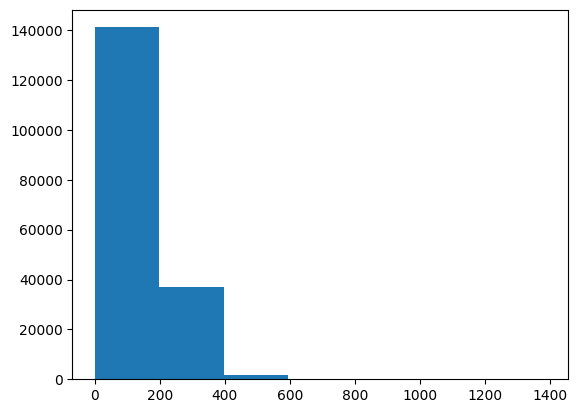

In [51]:
#Check the distribution of sequences at character_level
import matplotlib.pyplot as plt
plt.hist(chars_len,bins=7)

In [52]:
#Find what characters length covers 95% of sequences?
output_seq_char_len = int(np.percentile(chars_len,95))
output_seq_char_len

290

In [53]:
#Get all keywords characters
import string
alpha = string.ascii_lowercase + string.digits + string.punctuation
alpha

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [54]:
#Create chars_level token vectorizer instance
NUM_CHARS_TOKENS = len(alpha) + 2 #add 2 space and OOV(out of vocabulary)
char_vectorizer = TextVectorization(max_tokens=NUM_CHARS_TOKENS,
                                   output_mode="int",
                                   output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [55]:
#Adapt chars vectorizer to training chars
char_vectorizer.adapt(train_chars)

In [56]:
#Check chars vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of characters in vocab is: {len(char_vocab)}")
print(f"Top 5 characters in vocab: {char_vocab[:5]}")
print(f"Bottom 5 characters in vocab: {char_vocab[-5]}")

Number of characters in vocab is: 70
Top 5 characters in vocab: ['', '[UNK]', 'the', 'and', 'of']
Bottom 5 characters in vocab: pain


In [57]:
#Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Random sentence: {random_train_chars}")
print(f"\n Length of random_train_chars:{len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\n Vectorized chars: \n{vectorized_chars}")
print(f"\n length of vectorized chars: {vectorized_chars[0]}")

Random sentence: a positive association was observed between achieving undetectable serum androgens and psa decline ( testosterone : odds ratio = @ ; @ % confidence interval : @-@ @ ) .

 Length of random_train_chars:30

 Vectorized chars: 
[[ 8  1  1 10  1 30  1  1  1  1  3  1  1  1  1  1  1  1  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0

##Creating a character-level embedding

In [58]:
#Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,#size of character embedding given in paper
                              mask_zero=True,
                              name="char_embedding")

In [59]:
#Test our character embedding layer
print(f"Charified text:\n {random_train_chars}")
char_embed_ex = char_embed(vectorized_chars)
print(f"\n Embedded chars(after vectorization and embedding): {char_embed_ex}")
print(f"\n Embedded chars shape: {char_embed_ex.shape}")

Charified text:
 a positive association was observed between achieving undetectable serum androgens and psa decline ( testosterone : odds ratio = @ ; @ % confidence interval : @-@ @ ) .

 Embedded chars(after vectorization and embedding): [[[-0.02335111 -0.0181812  -0.04820208 ... -0.03250407 -0.03391502
   -0.0309893 ]
  [-0.01928283  0.02582688 -0.04381082 ... -0.01516136 -0.01259327
   -0.01774364]
  [-0.01928283  0.02582688 -0.04381082 ... -0.01516136 -0.01259327
   -0.01774364]
  ...
  [ 0.04094613 -0.02651029  0.04315424 ... -0.03320621  0.01432481
    0.02227795]
  [ 0.04094613 -0.02651029  0.04315424 ... -0.03320621  0.01432481
    0.02227795]
  [ 0.04094613 -0.02651029  0.04315424 ... -0.03320621  0.01432481
    0.02227795]]]

 Embedded chars shape: (1, 290, 25)


###Building a Conv1D model to fit on character embeddings

Before fitting our model on the data, we'll create char-level batched `PrefetchedDataset's`.

In [60]:
# Define the feature extraction model using TF Hub layer outside of any loop or function
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model outside of any loop or function
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "model_3_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embedding (Embedding)           │ (None, 290, 25)             │           1,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 290, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Create char datasets (using integer labels for sparse_categorical_crossentropy)
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

In [62]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4613 - loss: 1.2734 - val_accuracy: 0.6323 - val_loss: 0.8922
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6443 - loss: 0.8894 - val_accuracy: 0.6755 - val_loss: 0.8254
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6628 - loss: 0.8461 - val_accuracy: 0.6752 - val_loss: 0.8275


In [63]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6807 - loss: 0.8112


[0.8125186562538147, 0.6824440360069275]

In [64]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[3.6515826e-01, 4.6416289e-01, 2.4001664e-02, 1.3681999e-01,
        9.8571843e-03],
       [3.1540045e-01, 5.3131652e-01, 1.5487842e-02, 1.2267316e-01,
        1.5122066e-02],
       [4.7756663e-01, 1.0069722e-01, 6.2711090e-02, 3.5353673e-01,
        5.4883272e-03],
       [6.1388155e-03, 2.1733068e-02, 7.9873717e-01, 2.0966507e-03,
        1.7129423e-01],
       [3.7597918e-03, 2.6551243e-02, 5.2337998e-01, 1.2565983e-03,
        4.4505236e-01],
       [3.5747592e-04, 8.1857410e-04, 5.3733987e-01, 1.0320963e-04,
        4.6138087e-01],
       [4.8639784e-03, 3.7556835e-02, 5.0079077e-01, 1.3804106e-03,
        4.5540804e-01],
       [8.2077213e-02, 1.4780883e-01, 2.5800177e-01, 4.0910009e-02,
        4.7120219e-01],
       [2.9754944e-04, 1.0302898e-03, 4.2595272e-03, 8.7843579e-04,
        9.9353421e-01],
       [1.1318073e-02, 3.2576747e-02, 7.9536086e-01, 1.4399714e-02,
        1.4634457e-01]], dtype=float32)

In [65]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 0, ..., 4, 4, 0])>

In [66]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 68.24440619621342,
 'precision': 0.685786420250566,
 'recall': 0.6824440619621343,
 'f1': 0.6811277614835535}

##Model 4: Combining pretrained token embeddngs + character embeddings(hybrid embedding layer)

1. Create a token-level embedding model(similar `model 1`)
2. Create a character-level model(similar to `model_3` with slight modification)
3. Combining 1 & 2 with a concatenate(`using layers.Concatenate`) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/abs/1612.05251)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [67]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
# Wrap the TensorFlow Hub layer in a Lambda layer
token_embeddings = layers.Lambda(lambda x: tf_hub_embedding_layer(tf.cast(x, tf.string)))(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)
# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)

# Add a Masking layer to ensure right-padding
char_embeddings = layers.Masking(mask_value=0)(char_embeddings)  # Mask padding values (0)

char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [68]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embedding            │ (None, 290, 25)        │          1,750 │ char_vectorizer[1][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 290, 25)        │              0 │ char_embedding[1][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 512)            │              0 │ token_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking (Masking)         │ (None, 290, 25)        │              0 │ char_embedding[1][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, 290)            │              0 │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         65,664 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50)             │         10,200 │ masking[0][0],         │
│ (Bidirectional)           │                        │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 178)            │              0 │ dense_4[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 178)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 200)            │         35,800 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 200)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 5)              │          1,005 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 114,419 (446.95 KB)

 Trainable params: 114,419 (446.95 KB)

 Non-trainable params: 0 (0.00 B)

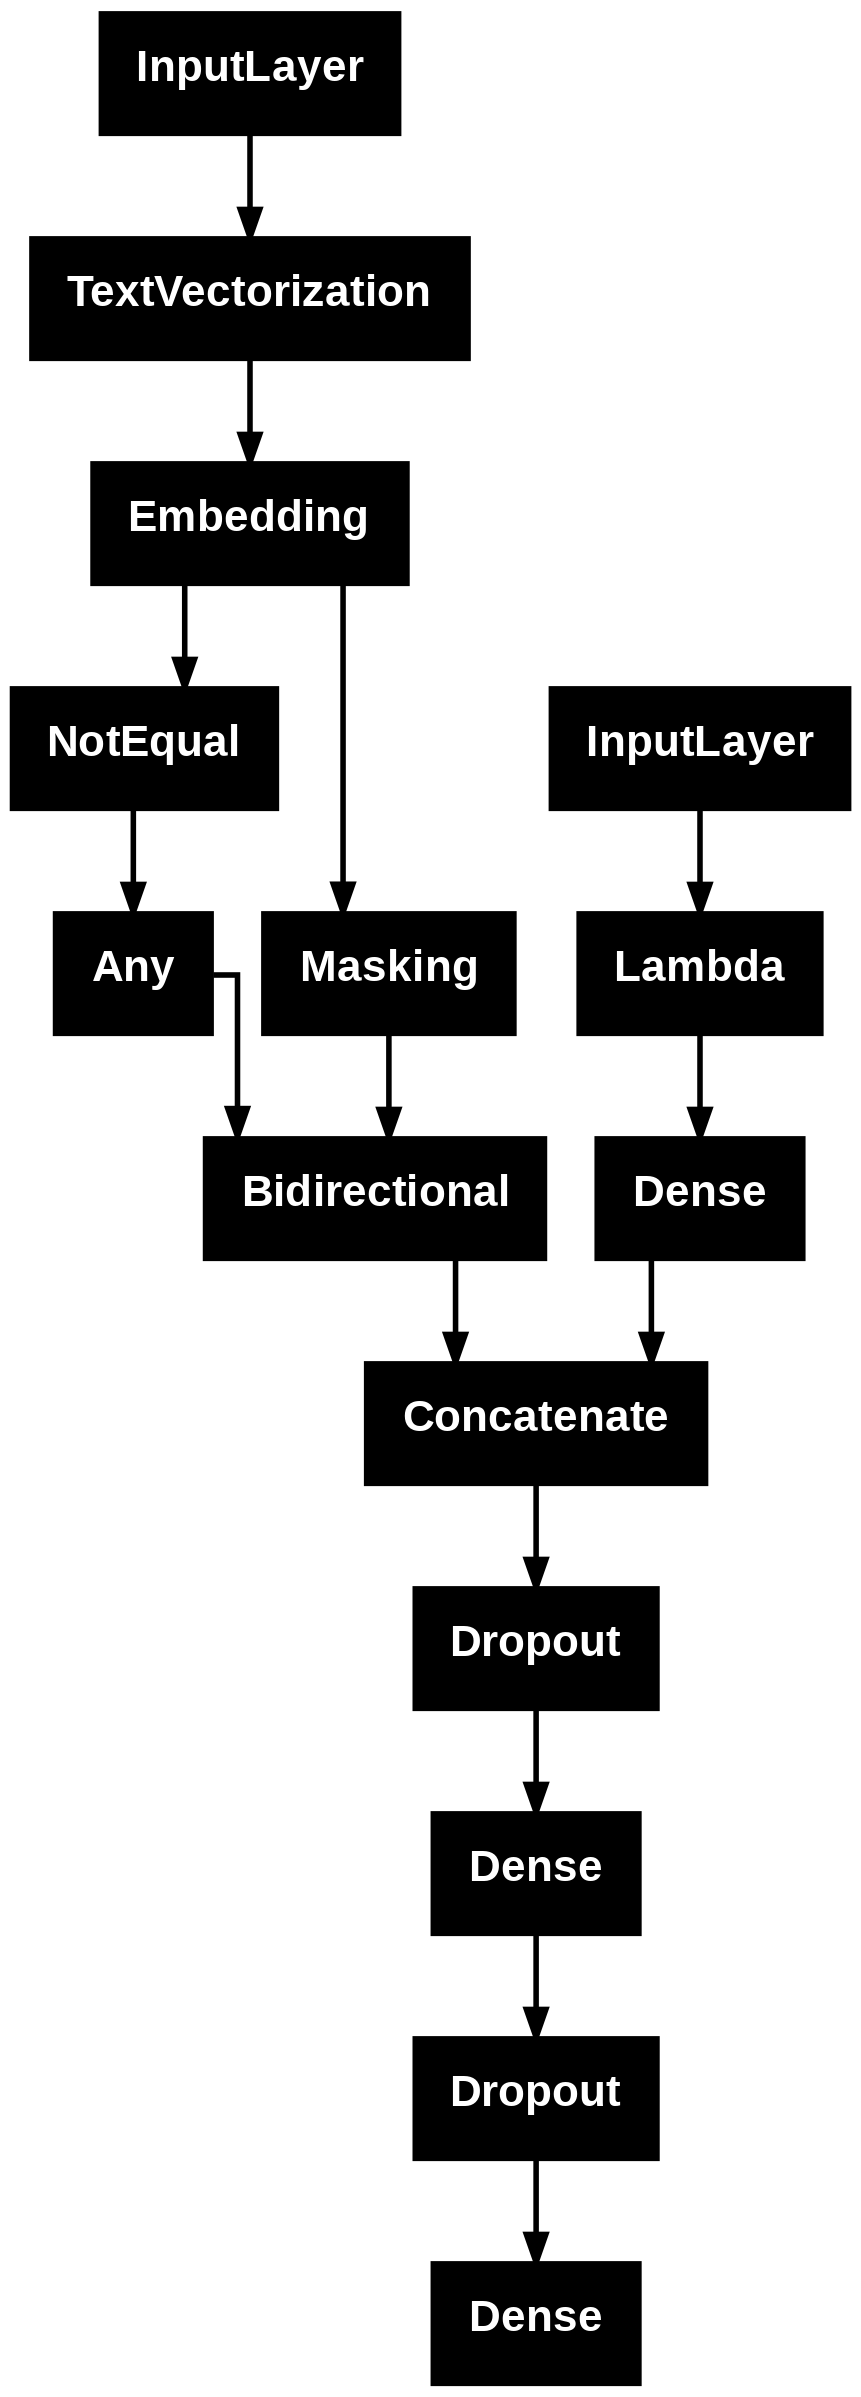

In [69]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [70]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

###Combining token and character data into a `tf.data` `dataset`

In [71]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [72]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

###Fitting a model on token and character-level sequences

In [92]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - accuracy: 0.7322 - loss: 0.7272 - val_accuracy: 0.7530 - val_loss: 0.6393
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.7434 - loss: 0.6812 - val_accuracy: 0.7620 - val_loss: 0.6136
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.7481 - loss: 0.6620 - val_accuracy: 0.7616 - val_loss: 0.6252


In [74]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.7497 - loss: 0.6493


[0.6474890112876892, 0.7517873644828796]

In [75]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step


array([[0.3955389 , 0.26068348, 0.0032926 , 0.33600307, 0.004482  ],
       [0.24794863, 0.624866  , 0.00384591, 0.1212227 , 0.00211679],
       [0.2372644 , 0.04324143, 0.01784004, 0.6966335 , 0.00502063],
       ...,
       [0.00532513, 0.02868393, 0.15301007, 0.00258672, 0.8103941 ],
       [0.00998976, 0.06520357, 0.15989152, 0.00495911, 0.75995606],
       [0.40860176, 0.34034026, 0.17071104, 0.03671408, 0.04363283]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

In [77]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 75.17873692572488,
 'precision': 0.7506902463089494,
 'recall': 0.7517873692572488,
 'f1': 0.7488576446552347}

##Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

**Note:** Any engineered features used to train a model need to be available at test time.In this case,line numbers and total lines are available

###Creating positional embeddings

In [78]:
#How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

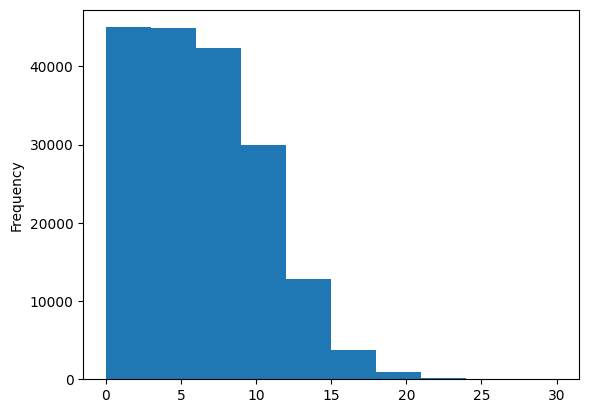

In [79]:
#Distribution of "line_number" column checking
train_df.line_number.plot.hist()

In [80]:
#Using Tensorflow to create one_hot_encoding tensors for line_number
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_number_one_hot[:5]

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [81]:
#How many different no.of lines are there?
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


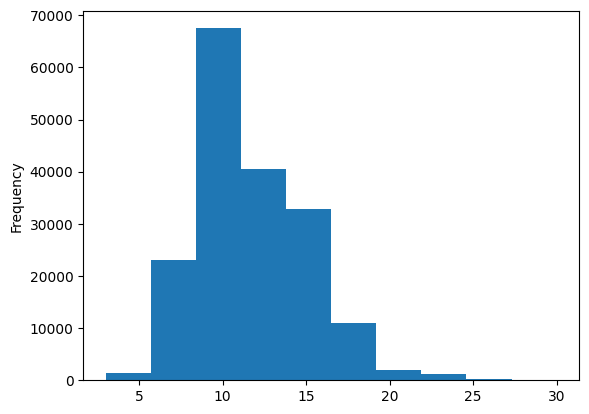

In [82]:
#Checking the distribution of total lines
train_df.total_lines.plot.hist();

In [83]:
#Checking the coverage of "total lines" values of 20
np.percentile(train_df.total_lines,98)

20.0

In [84]:
#Using tensorflow to create one_hot_encoding tensors
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot[:5],train_total_lines_one_hot.shape

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 20]))

In [101]:
import tensorflow as tf
from tensorflow.keras import layers

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = layers.Lambda(lambda x: tf_hub_embedding_layer(tf.cast(x, tf.string)))(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)

# Add Masking layer for padding
masked_char_embeddings = layers.Masking(mask_value=0.0)(char_embeddings)  # Add Masking layer here

# Disable cuDNN to allow for masking without right-padding restrictions
char_bi_lstm = layers.Bidirectional(layers.LSTM(32, use_cudnn=False))(masked_char_embeddings)  # Disable cuDNN here
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output, total_line_model.output, z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input, total_line_model.input, token_model.input, char_model.input],
                         outputs=output_layer)

# Model summary to verify the structure
model_5.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embedding            │ (None, 290, 25)        │          1,750 │ char_vectorizer[5][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_8 (NotEqual)    │ (None, 290, 25)        │              0 │ char_embedding[5][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 512)            │              0 │ token_inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking_1 (Masking)       │ (None, 290, 25)        │              0 │ char_embedding[5][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any_1 (Any)               │ (None, 290)            │              0 │ not_equal_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 128)            │         65,664 │ lambda_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 64)             │         14,848 │ masking_1[0][0],       │
│ (Bidirectional)           │                        │                │ any_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid_embedd… │ (None, 192)            │              0 │ dense_19[0][0],        │
│ (Concatenate)             │                        │                │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input         │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_input         │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 256)            │         49,408 │ token_char_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 32)             │            512 │ line_number_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 32)             │            672 │ total_lines_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)  

 Total params: 134,459 (525.23 KB)

 Trainable params: 134,459 (525.23 KB)

 Non-trainable params: 0 (0.00 B)

###Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" features
4. Create a model for "total_lines" features
5. Combine o/p's of 1 & 2 `tf.keras.layers.Concatenate`
6. Combine the o/p's of 3 ,4 & 5 using the `tf.keras.layers.Concatenate`
7. Create o/p layers to accept the tribrid embedding and o/p label probabilites
8. Combine inputs of 1, 2, 3, 4 & outputs of into a `tf.keras.Model`

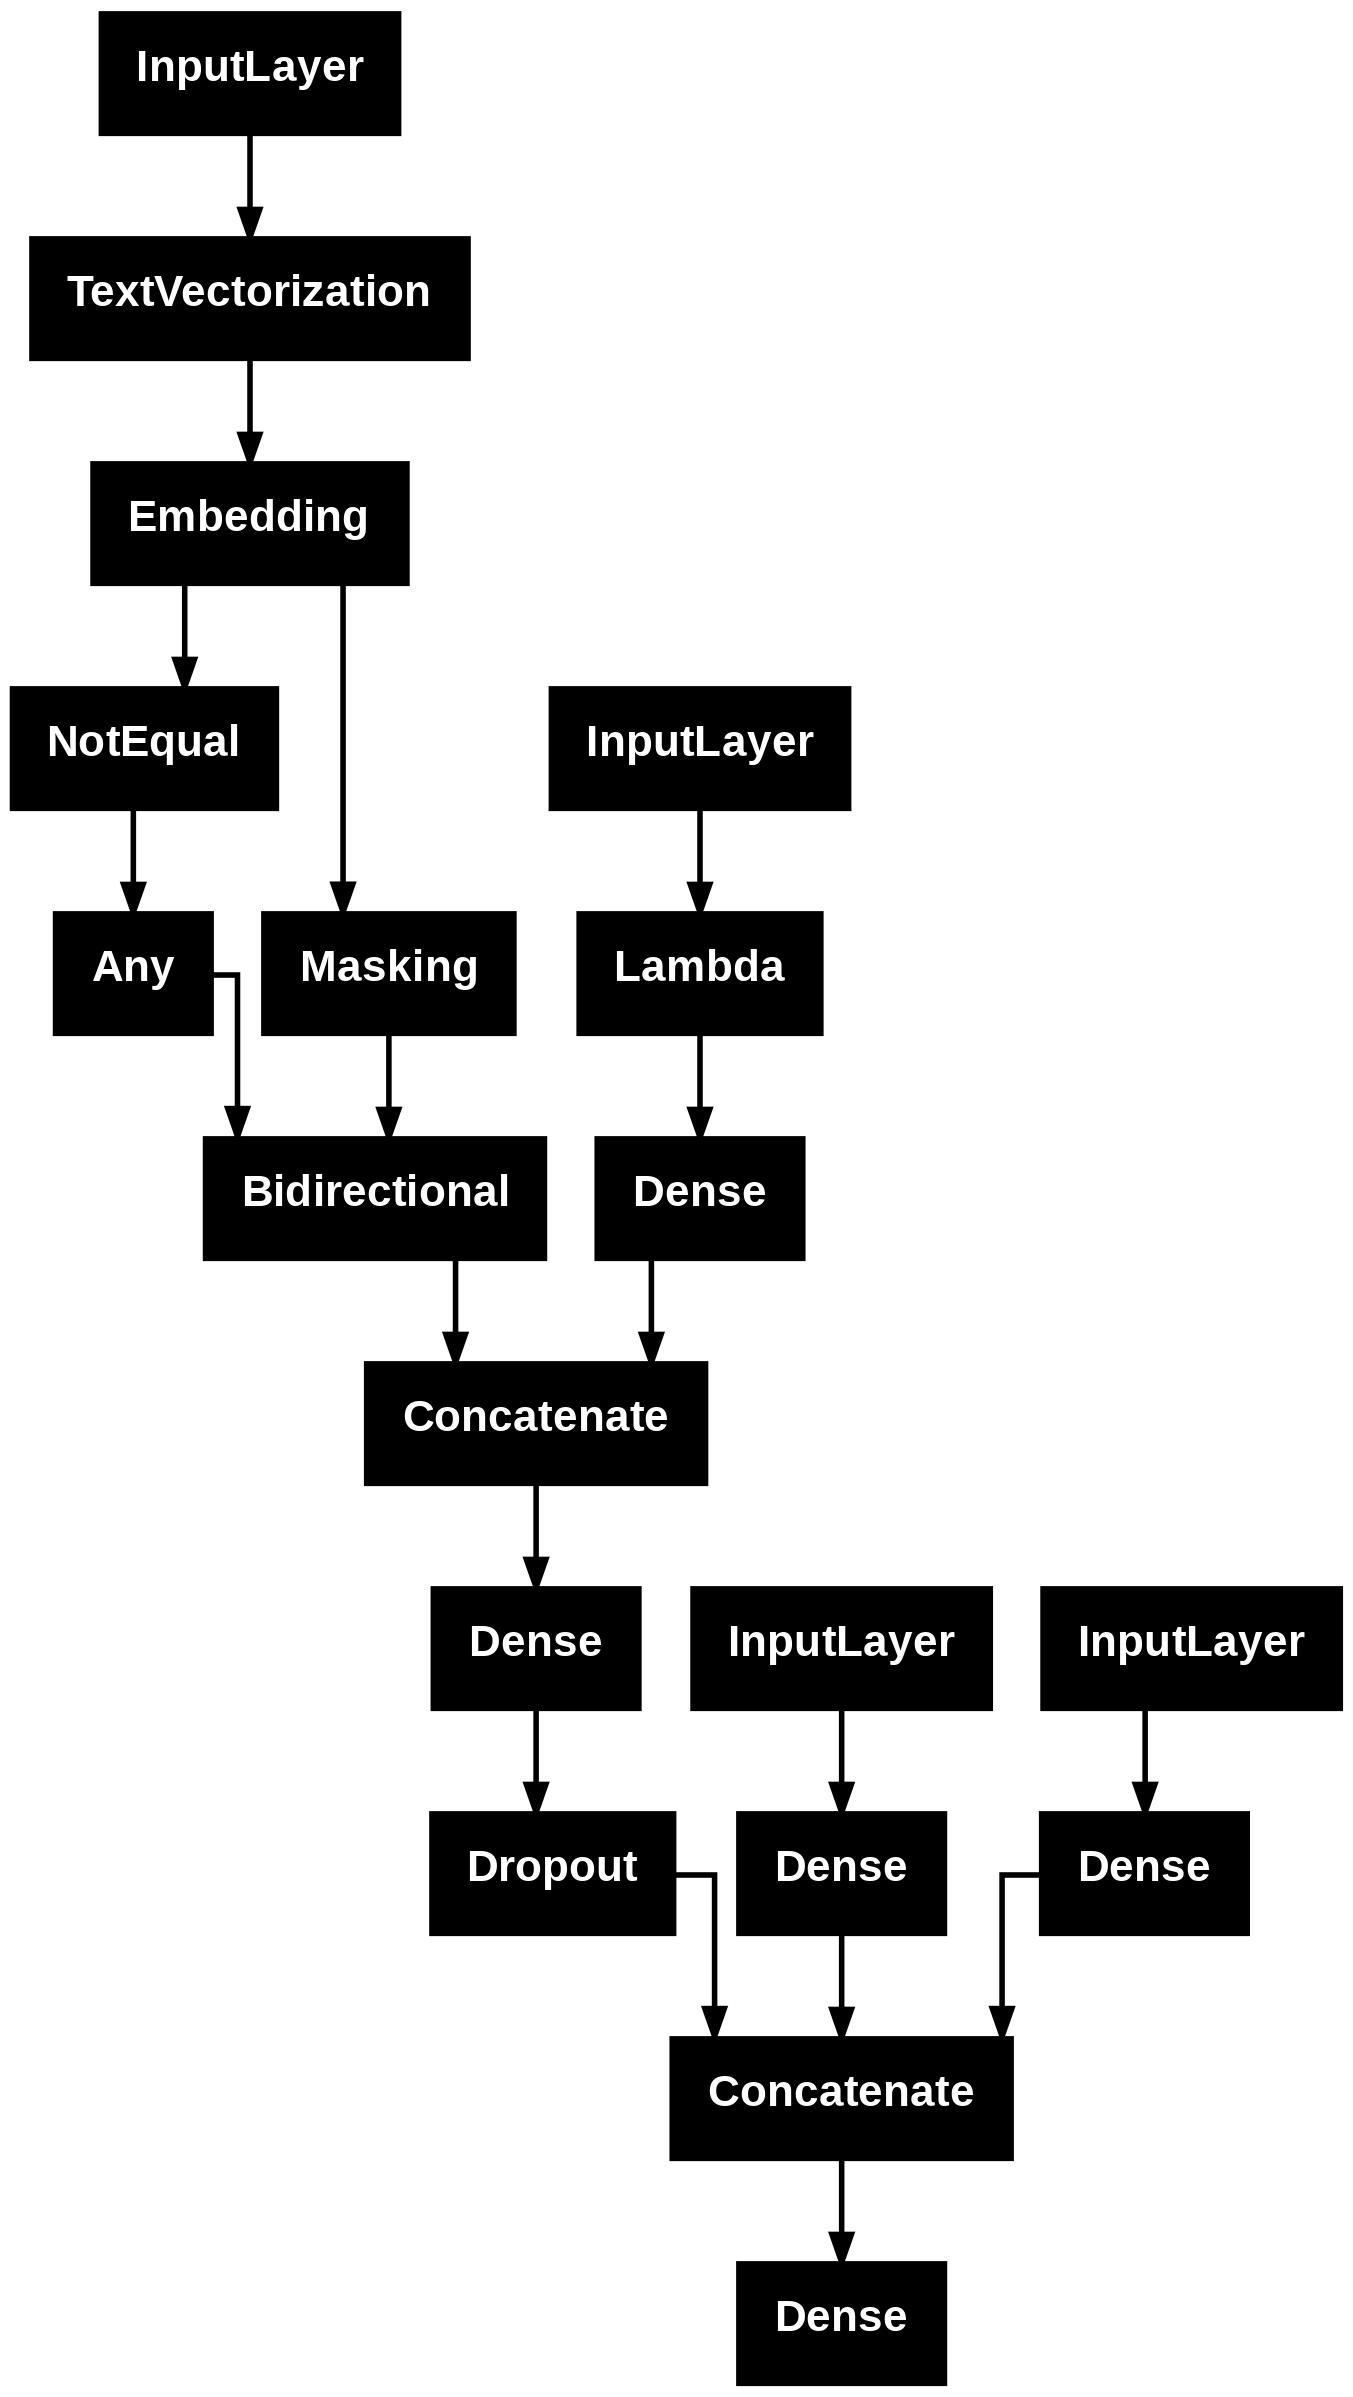

In [105]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [88]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<InputLayer name=char_inputs, built=True> True
<InputLayer name=token_inputs, built=True> True
<TextVectorization name=char_vectorizer, built=True> True
<Lambda name=lambda_2, built=True> True
<Embedding name=char_embedding, built=True> True
<Dense name=dense_7, built=True> True
<Bidirectional name=bidirectional_1, built=True> True
<Concatenate name=token_char_hybrid_embedding, built=True> True
<InputLayer name=line_number_input, built=True> True
<InputLayer name=total_lines_input, built=True> True
<Dense name=dense_10, built=True> True
<Dense name=dense_8, built=True> True
<Dense name=dense_9, built=True> True
<Dropout name=dropout_2, built=True> True
<Concatenate name=token_char_positional_embedding, built=True> True
<Dense name=output_layer, built=True> True


In [102]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

###Create tribrid embedding datasets and fit tribrid model

Model compiled!

Again, to keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:

    1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
    2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
    3. Token-level sequences tensor (`train_sentences`)
    4. Char-level sequences tensor (`train_chars`)

We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batched `PrefetchedDataset's`.


In [103]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately


# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [104]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.6477 - loss: 1.1950 - val_accuracy: 0.8168 - val_loss: 0.9604
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8214 - loss: 0.9606 - val_accuracy: 0.8358 - val_loss: 0.9214
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - accuracy: 0.8291 - loss: 0.9405 - val_accuracy: 0.8324 - val_loss: 0.9274


In [106]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step


array([[0.457907  , 0.08288713, 0.00835816, 0.4344462 , 0.01640161],
       [0.5467057 , 0.12837988, 0.03653612, 0.28148735, 0.00689101],
       [0.26524875, 0.10983182, 0.0817633 , 0.5006759 , 0.0424802 ],
       ...,
       [0.03615948, 0.2062301 , 0.06507871, 0.03683332, 0.6556984 ],
       [0.03321537, 0.35952982, 0.05953639, 0.03153855, 0.51617986],
       [0.21458106, 0.5866437 , 0.08715435, 0.0459992 , 0.06562166]],
      dtype=float32)

In [107]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [108]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.98980537534754,
 'precision': 0.8397515254550891,
 'recall': 0.8398980537534755,
 'f1': 0.8394648022252182}

##Compare model results


Now it's time to compare each model's performance against each other.

We'll also be able to compare our model's to the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper.

Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them.

In [120]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.680657,0.783612,0.786807,0.784790
custom_char_embed_conv1d,68.244406,0.685786,0.682444,0.681128
hybrid_char_token_embed,75.178737,0.750690,0.751787,0.748858
tribrid_pos_char_token_embed,83.989805,0.839752,0.839898,0.839465


from matplotlib import pyplot as plt
all_model_results['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results.plot(kind='scatter', x='accuracy', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
all_model_results['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

In [121]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

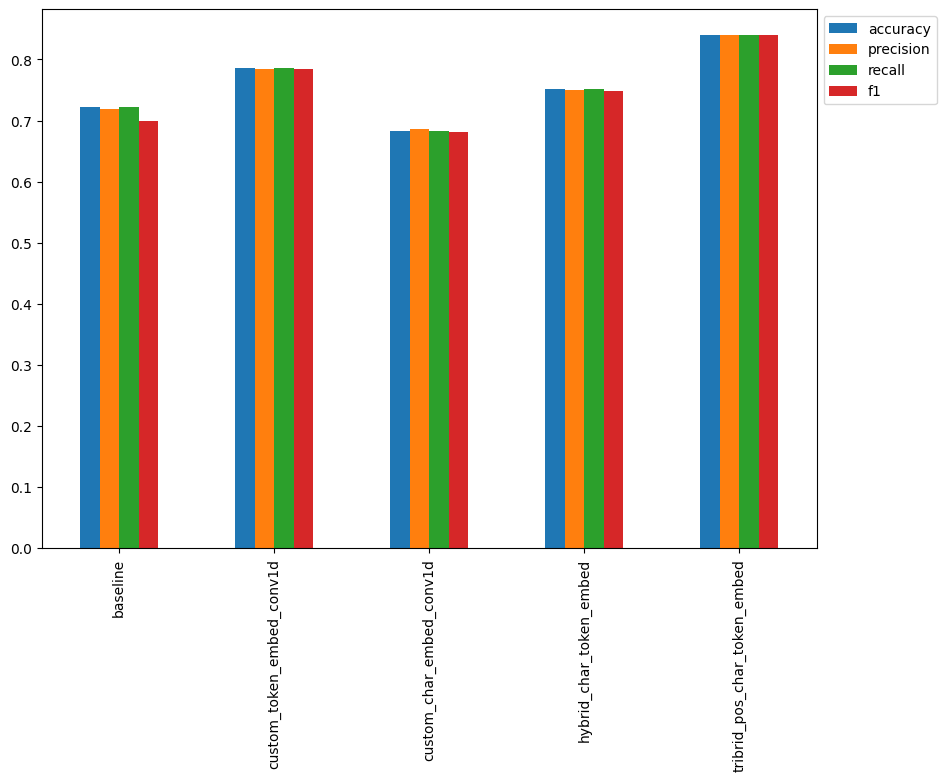

In [122]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Since the `PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts` paper compares their tested model's F1-scores on the test dataset, let's take at our model's F1-scores.

> 🔑 Note: We could've also made these comparisons in TensorBoard using the `TensorBoard` `callback during training.`

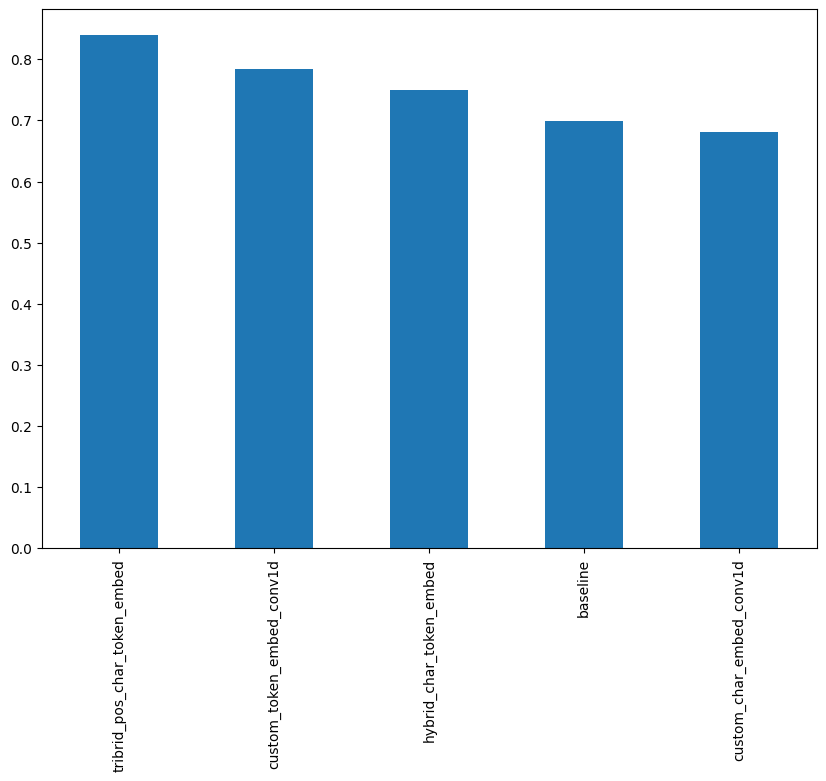

In [124]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Though, in comparison to the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, our model's F1-score is still underperforming (the authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~82.6).